# CO2 Concentration in the Atmosphere

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


The data file weekly_in_situ_co2_mlo.csv is downloaded from https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html. Download date 03/01/2025 14:29.


In [6]:
data = pd.read_csv('weekly_in_situ_co2_mlo.csv', 
                       names = ['date', 'CO2 Concentration ppm'],
                       sep = ',', 
                       skiprows = 44)

In [7]:
data

,date,CO2 Concentration ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48
...,...,...
3398,2024-10-12,422.13
3399,2024-10-19,422.16
3400,2024-10-26,422.36
3401,2024-11-02,423.15


Lets check for missing data. 

In [9]:
data[data.isnull().any(axis=1)]

,date,CO2 Concentration ppm


So there are no rows with missing data, good! 

Let's make a 2nd column of dates which are datetime objects, for later better usability.

In [10]:
data['datetimes'] = pd.to_datetime(data['date'],format='%Y-%m-%d')

Now lets plot the data:

<Axes: title={'center': 'CO2 Concentration, weekly values'}, xlabel='Date', ylabel='CO2 Concentration /ppm'>

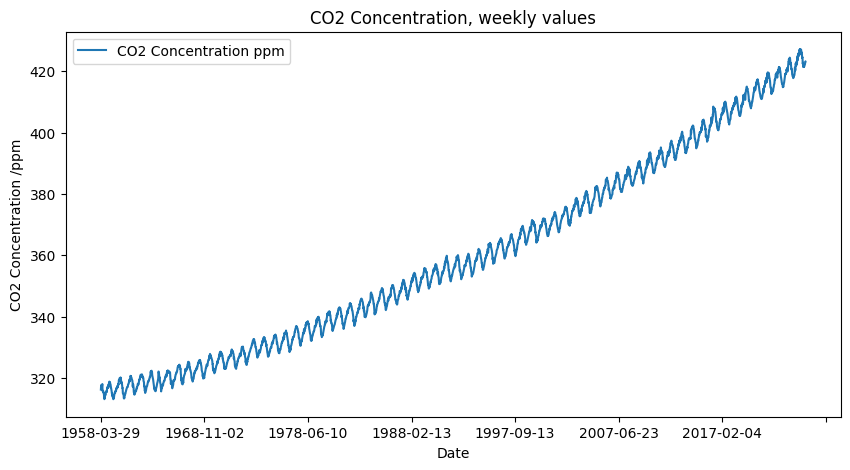

In [11]:
data.plot(x = 'date', y='CO2 Concentration ppm', kind = 'line', title = 'CO2 Concentration, weekly values', ylabel = 'CO2 Concentration /ppm', xlabel = 'Date', figsize = (10, 5))

The plot seems to consist of a superposition of a) a (relatively) short term oscillation and b) a slower long-term development. Instinctively, the short term trend can be modelled using a trigonometric function, whereas the slower development looks like a 2nd degree polynomial or exponential function. Let's try to fit a model expressing this. In order to do this, we will need the date to be a variable (x) that is steadily increasing, instead of dates as it is now. We should convert the dates into variable 'days' starting from 0 at first data point summing up to date of last data point.

In [12]:
start = data['datetimes'][0] # set start date

data['days'] = (data['datetimes']-start).dt.days
data.head()

,date,CO2 Concentration ppm,datetimes,days
0,1958-03-29,316.19,1958-03-29,0
1,1958-04-05,317.31,1958-04-05,7
2,1958-04-12,317.69,1958-04-12,14
3,1958-04-19,317.58,1958-04-19,21
4,1958-04-26,316.48,1958-04-26,28


To characterise the oscillating function, we can look at shorter timespans to rid the long-term evolution from having an effect. Lets look at the 1st year:

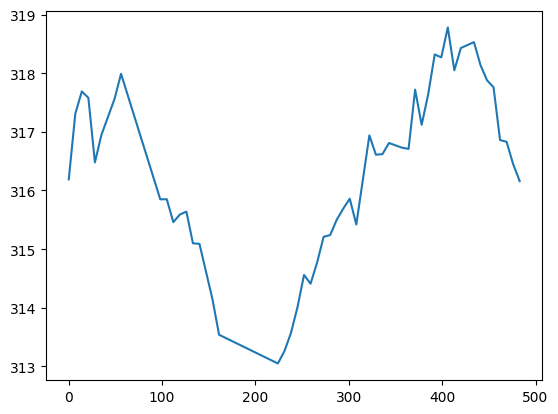

In [67]:
X = data['days'][0:52]
Y = data['CO2 Concentration ppm'][0:52]
plt.plot(X, Y)

Why is the first 52 weeks containing almost 500 days? Should contain exactly 356 days, something is clearly wrong.

In [76]:
data[7:9]

,date,CO2 Concentration ppm,date2,datetimes,days
7,1958-05-24,317.99,1958-05-24,1958-05-24,56
8,1958-07-05,315.85,1958-07-05,1958-07-05,98


Manual inspection has shown that there is a gap of over a month between rows 7-8. I've further realized that this is not a problem per se, since the 'days' column is still accurately counting the days. So we can proceed with the data as is. 

Let's continute with our modelling by fitting a 2nd degree model to the data. We will then plot the 2nd degree model and the CO2 concentration data in the same plot.

Text(0.5, 0, 'days from 1958-03-29')

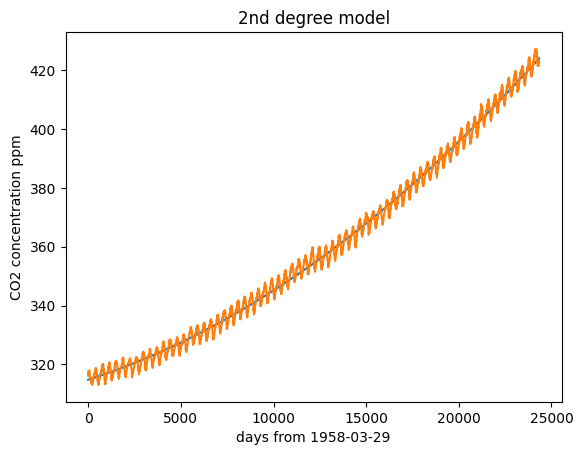

In [19]:
model = np.polyfit(data['days'], data['CO2 Concentration ppm'], deg = 2)
data['2nd deg pol'] = model[0] * data['days']**2 +  model[1] * data['days'] + model[2]
plt.plot(data['days'], data['2nd deg pol'])
plt.plot(data['days'], data['CO2 Concentration ppm'])
plt.title('2nd degree model')
plt.ylabel('CO2 concentration ppm')
plt.xlabel('days from 1958-03-29')

Lets visualise the residuals:

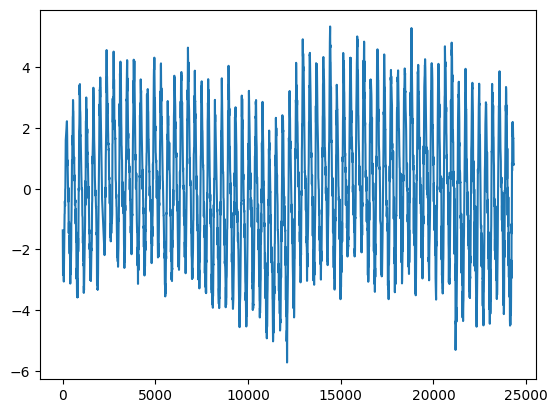

In [20]:
plt.plot(data['days'], data['2nd deg pol'] - data['CO2 Concentration ppm'])

We see no clear trend in the residuals, which suggests that there is no inherent issue in using a 2nd degree polynomial model. We are happy with this model explaining the long-term evolution of the CO2 concentration data, and we will now turn our attention to the short-term behavior. Our model will consist of a trigonometric function + the 2nd degree polynomial we have determined. 

Since the short-term behavior is hypothesized (and seen in data) to vary on a yearly basis, we can take the frequency parameter to be 2$\pi$/365.25 and try for this value first. This way we can reduce the number of parameters in the model by one. 

In [49]:
def fullmodel(x, a0, a1, a2, a3, a4):
    return a0 + a1 * x + a2 * x ** 2 + a3 * np.sin(2*np.pi/365.25 * x + a4)

param, cov = curve_fit(fullmodel, data['days'], data['CO2 Concentration ppm'])
data['trig + 2nd deg pol'] = param[0] + param[1] * data['days'] + param[2] * data['days']**2 + param[3] * np.sin(2*np.pi/365.25 * data['days'] + param[4])

data['trig + 2nd deg pol residuals'] =  data['trig + 2nd deg pol'] - data['CO2 Concentration ppm']




Plotting the original data and our complete model:

Text(0.5, 0, 'days from 1958-03-29')

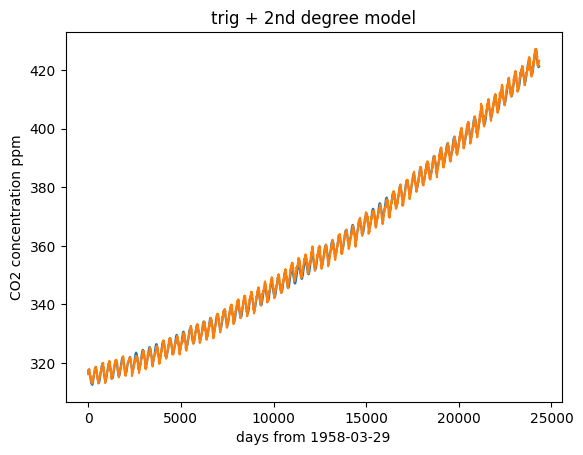

In [51]:
plt.plot(data['days'], data['trig + 2nd deg pol'])
plt.plot(data['days'], data['CO2 Concentration ppm'])
plt.title('trig + 2nd degree model')
plt.ylabel('CO2 concentration ppm')
plt.xlabel('days from 1958-03-29')


Plotting the residuals from the complete model:

Text(0.5, 0, 'days from 1958-03-29')

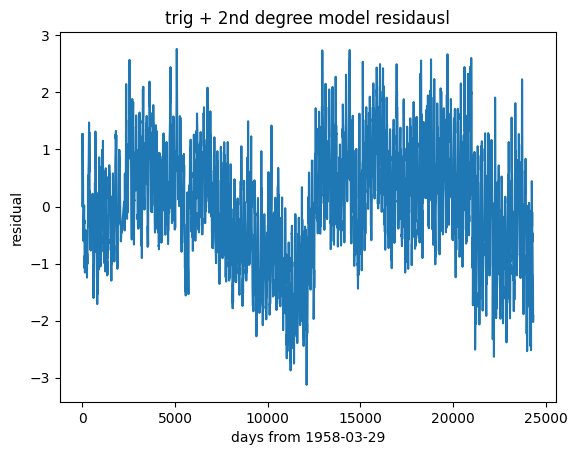

In [62]:
plt.plot(data['days'], data['trig + 2nd deg pol residuals'])
plt.title('trig + 2nd degree model residausl')
plt.ylabel('residual')
plt.xlabel('days from 1958-03-29')


Since we see no trend or reoccuring behavior in the plot of the residuals, we can conclude that our model '2nd degree + trig wholly explains the trends present in the data. 

2. ### Let's finally use our model to extrapolate to 2025. As the year goes on we will then be able to check our prediction versus the real time data being collected.

In [63]:
data

,date,CO2 Concentration ppm,datetimes,days,2nd deg pol,trig + 2nd deg pol,trig + 2nd deg pol residuals
0,1958-03-29,316.19,1958-03-29,0,314.819871,317.458363,1.268363
1,1958-04-05,317.31,1958-04-05,7,314.834004,317.591191,0.281191
2,1958-04-12,317.69,1958-04-12,14,314.848148,317.684275,-0.005725
3,1958-04-19,317.58,1958-04-19,21,314.862302,317.736470,0.156470
4,1958-04-26,316.48,1958-04-26,28,314.876465,317.747226,1.267226
...,...,...,...,...,...,...,...
3398,2024-10-12,422.13,2024-10-12,24304,423.786271,420.955433,-1.174567
3399,2024-10-19,422.16,2024-10-19,24311,423.834916,420.971192,-1.188808
3400,2024-10-26,422.36,2024-10-26,24318,423.883571,421.028437,-1.331563
3401,2024-11-02,423.15,2024-11-02,24325,423.932235,421.127043,-2.022957
